In [1]:
! hostname
! whoami
! pwd
# ! nvidia-smi

dhcp-10-29-100-233.dyn.mit.edu
akarshkumar0101
/Users/akarshkumar0101/exploration-generalization


In [2]:
%load_ext autoreload
%autoreload 2

In [282]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from functools import partial
from einops import rearrange, repeat
import gymnasium as gym
# import gym as gym_old
import gym
from tqdm.auto import tqdm
import cv2
import os
import re
# from ppo import *
import time

import procgen
from procgen import ProcgenEnv

from IPython.display import clear_output

import env_utils
import models
import ppo_rnd
import train
import pretrain
import bc
from pretrain import get_level2files

In [283]:
import wandb
api = wandb.Api()

In [284]:
runs = api.runs('akarshkumar0101/egb3')

In [285]:
run = runs[0]

In [286]:
np.min([run.summary['meta/SPS'] for run in runs])

734

In [287]:
(25e6/621)/3600

11.18268026480587

In [288]:
for run in runs:
    percent_done = run.summary['meta/global_step']/run.config['total_timesteps']
    hours_left = (run.config['total_timesteps'] - run.summary['meta/global_step'])/run.summary['meta/SPS']/3600
    
    print(f'{run.state}, {percent_done*100:05.1f}% progressed    {hours_left: 4.1f} hours left')

crashed, 099.8% progressed     0.0 hours left
crashed, 099.7% progressed     0.0 hours left
crashed, 099.8% progressed     0.0 hours left
crashed, 099.7% progressed     0.0 hours left
crashed, 099.7% progressed     0.0 hours left
crashed, 099.8% progressed     0.0 hours left
crashed, 099.7% progressed     0.0 hours left
crashed, 099.7% progressed     0.0 hours left
crashed, 099.8% progressed     0.0 hours left
crashed, 099.8% progressed     0.0 hours left
crashed, 099.7% progressed     0.0 hours left
crashed, 099.7% progressed     0.0 hours left
crashed, 099.8% progressed     0.0 hours left
crashed, 099.8% progressed     0.0 hours left
crashed, 099.7% progressed     0.0 hours left
crashed, 099.7% progressed     0.0 hours left
crashed, 099.8% progressed     0.0 hours left
crashed, 099.8% progressed     0.0 hours left
crashed, 099.8% progressed     0.0 hours left
crashed, 099.7% progressed     0.0 hours left
crashed, 099.7% progressed     0.0 hours left
crashed, 099.8% progressed     0.0

In [289]:
data = dict()
for run in runs:
    obj, num_levels = run.config['obj'], run.config['num_levels']
    if obj not in data:
        data[obj] = {}
    if num_levels not in data[obj]:
        data[obj][num_levels] = []
    data[obj][num_levels].append(run)

In [290]:
for num_levels in sorted(data['ext'].keys()):
    ret_ext_train = [run.summary['charts/ret_ext_train'] for run in data['ext'][num_levels]]
    ret_ext_test = [run.summary['charts/ret_ext_test'] for run in data['ext'][num_levels]]
    print(num_levels)
    print(f'{np.mean(ret_ext_train): 5.2f} - {np.mean(ret_ext_test): 5.2f}')
    print()

10
 13.00 -  2.17

100
 12.82 -  9.26

1000
 11.60 -  11.40



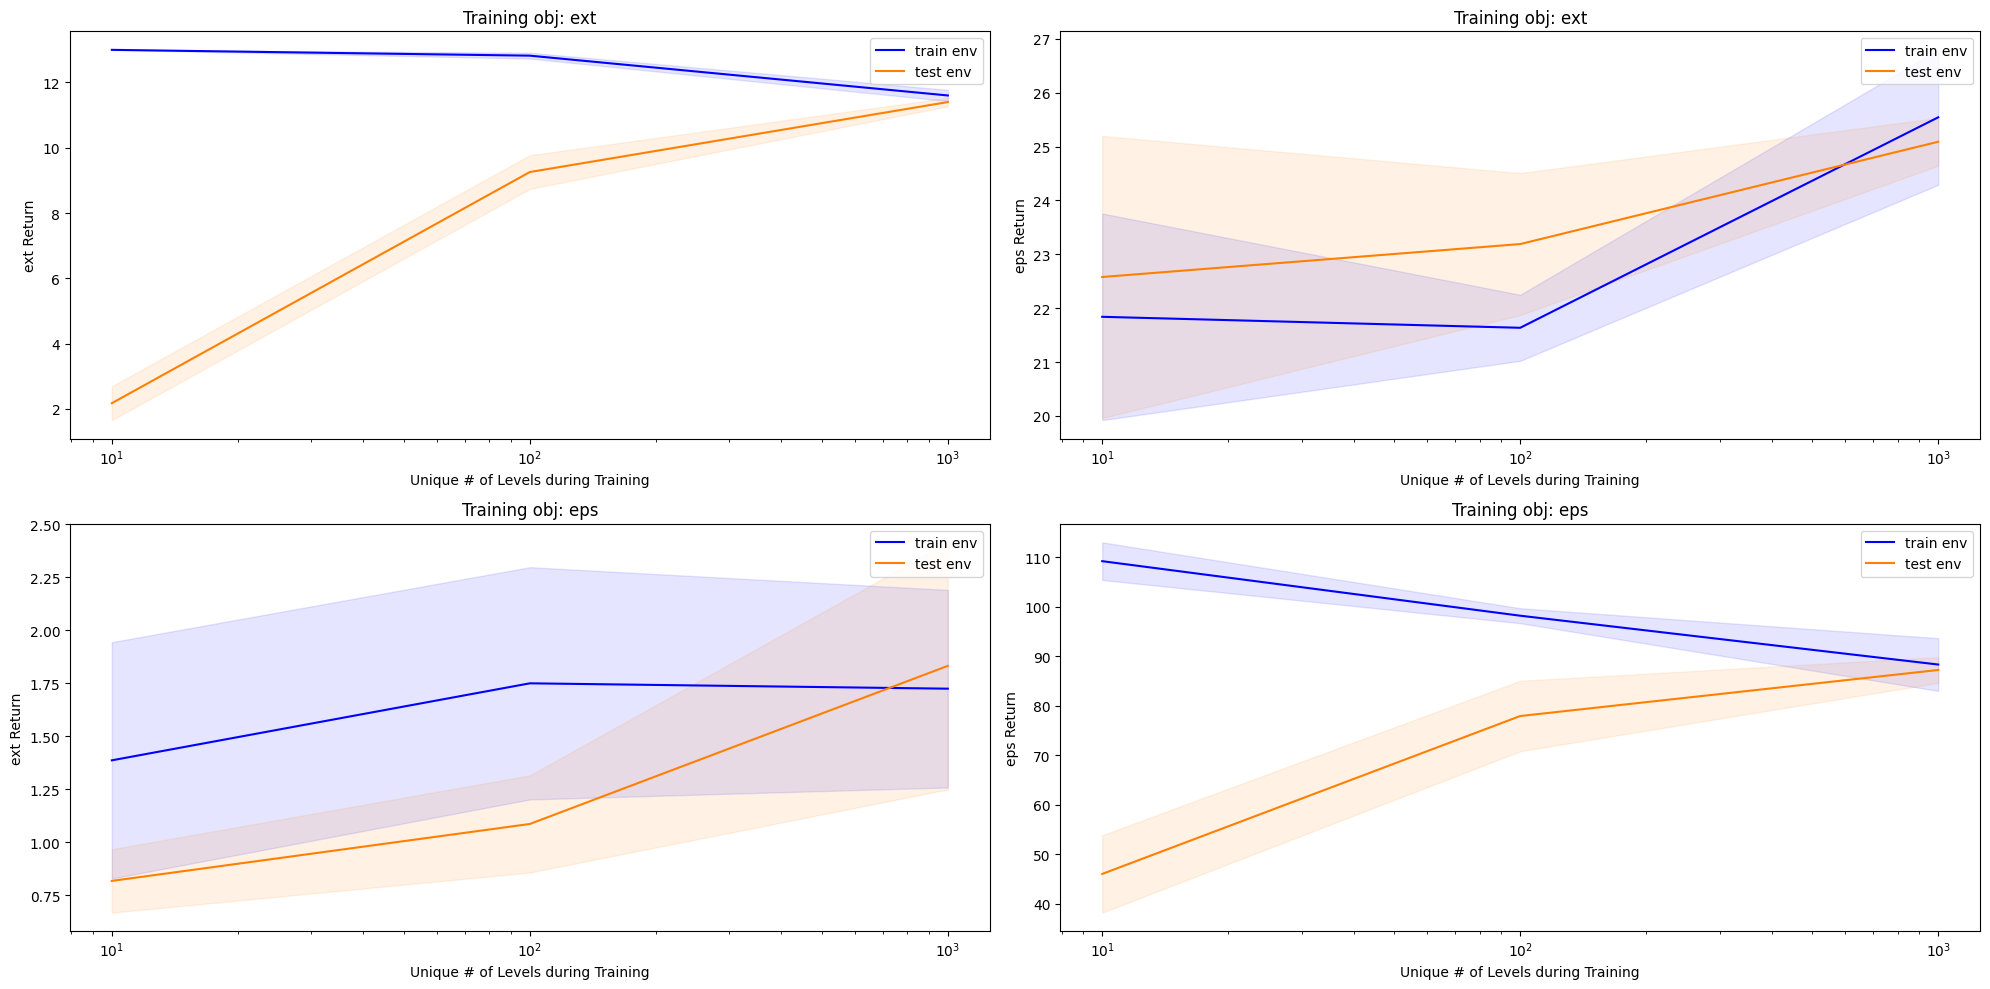

In [291]:

plt.figure(figsize=(20, 10))
i_subplot = 0
for obj_train in ['ext', 'eps']:
    for obj_eval in ['ext', 'eps']:
        i_subplot += 1
        plt.subplot(2, 2, i_subplot)
        
        x = sorted(data[obj_train].keys())
        
        y = np.array([np.mean([run.summary[f'charts/ret_{obj_eval}_train'] for run in data[obj_train][num_levels]]) for num_levels in x])
        y_std = np.array([np.std([run.summary[f'charts/ret_{obj_eval}_train'] for run in data[obj_train][num_levels]]) for num_levels in x])
        plt.plot(x, y, label='train env', color=[0, 0, 1])
        plt.fill_between(x, y-y_std, y+y_std, color=[0, 0, 1, .1])
        
        y = np.array([np.mean([run.summary[f'charts/ret_{obj_eval}_test'] for run in data[obj_train][num_levels]]) for num_levels in x])
        y_std = np.array([np.std([run.summary[f'charts/ret_{obj_eval}_test'] for run in data[obj_train][num_levels]]) for num_levels in x])
        plt.plot(x, y, label='test env', color=[1, .5, 0])
        plt.fill_between(x, y-y_std, y+y_std, color=[1, .5, 0, .1])
        
        plt.xscale('log')
        plt.xlabel('Unique # of Levels during Training')
        plt.ylabel(f'{obj_eval} Return')
        # plt.title(f'Training obj: {obj_train}, Eval Obj: {obj_eval}')
        plt.title(f'Training obj: {obj_train}')
        plt.legend()
plt.tight_layout()
plt.show()

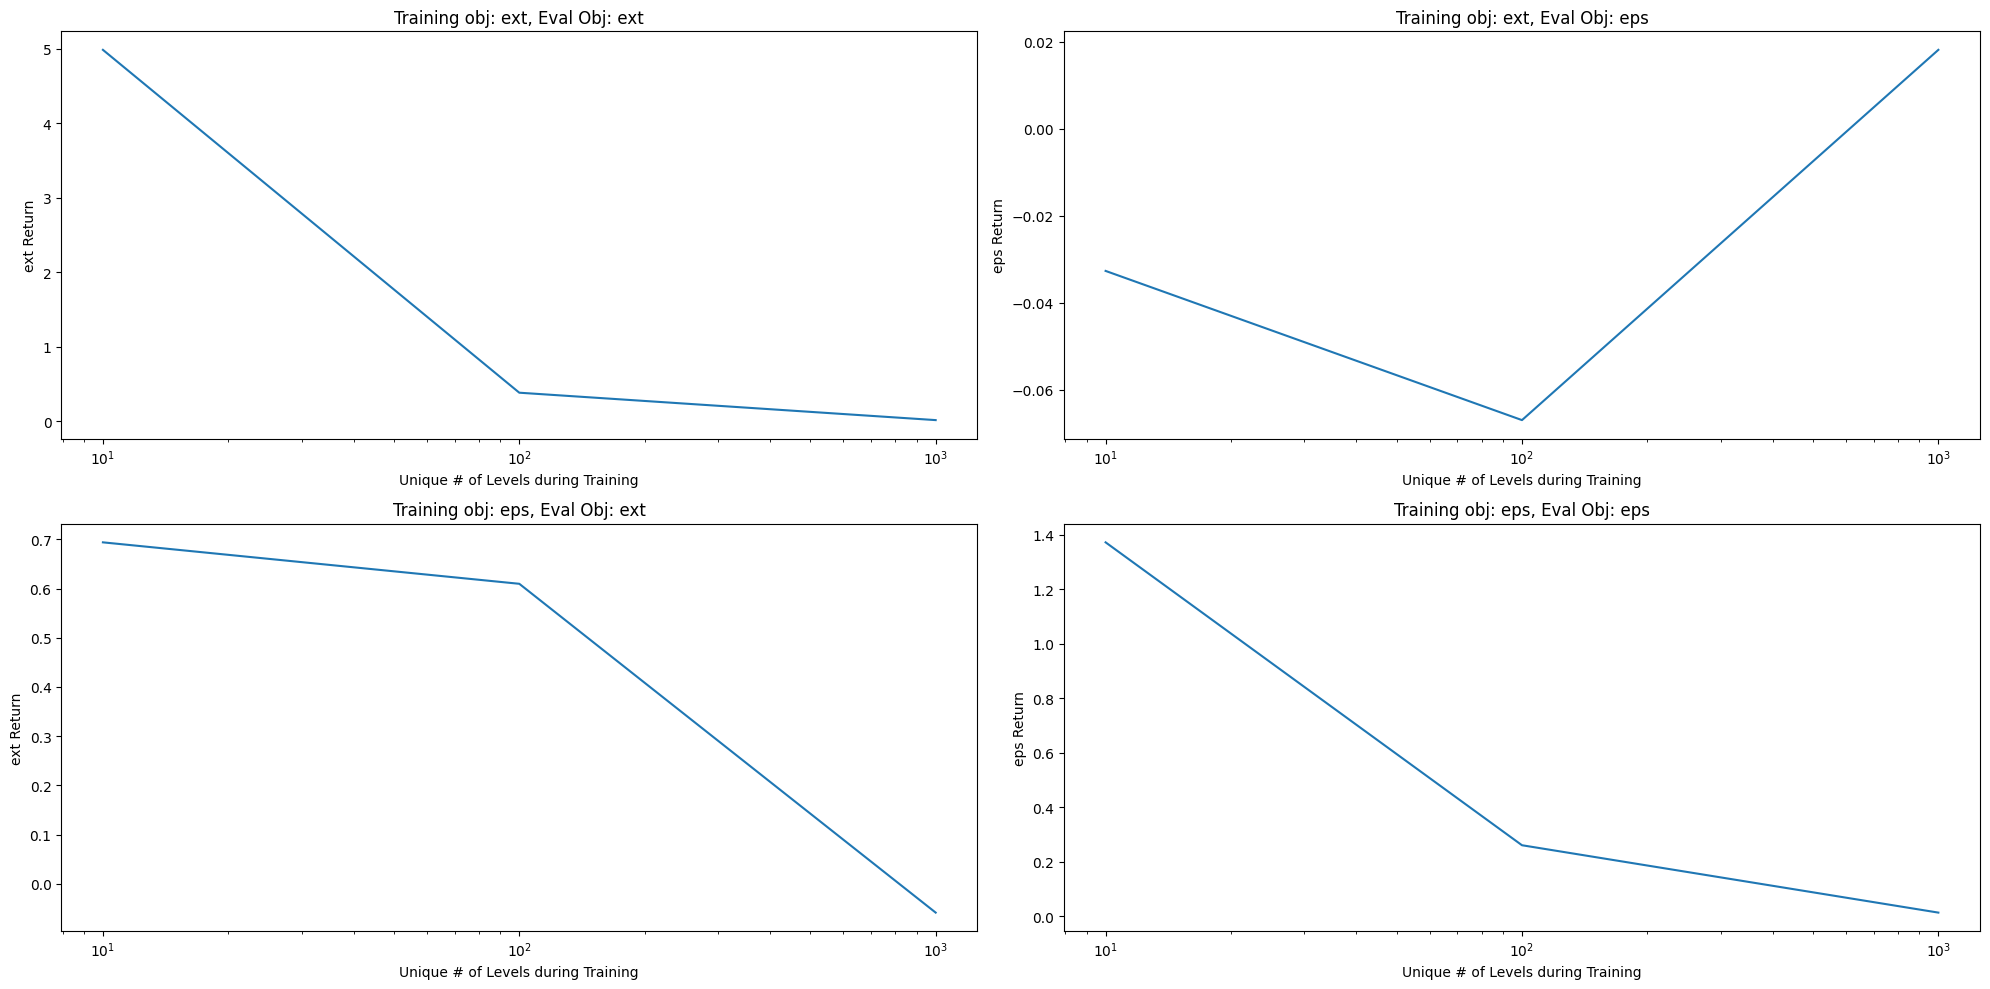

In [292]:
plt.figure(figsize=(20, 10))
i_subplot = 0
for obj_train in ['ext', 'eps']:
    for obj_eval in ['ext', 'eps']:
        i_subplot += 1
        x = sorted(data[obj_train].keys())
        ret_ext_train = np.array([np.mean([run.summary[f'charts/ret_{obj_eval}_train'] for run in data[obj_train][num_levels]]) for num_levels in x])
        ret_ext_test = np.array([np.mean([run.summary[f'charts/ret_{obj_eval}_test'] for run in data[obj_train][num_levels]]) for num_levels in x])

        plt.subplot(2, 2, i_subplot)
        plt.plot(x, (ret_ext_train-ret_ext_test)/ret_ext_test)
        plt.xscale('log')
        plt.xlabel('Unique # of Levels during Training')
        plt.ylabel(f'{obj_eval} Return')
        plt.title(f'Training obj: {obj_train}, Eval Obj: {obj_eval}')
plt.tight_layout()
plt.show()

In [304]:
f'{1e-0:05.0e}'

'1e+00'